## *EuroSAT RGB image classification*

# Inroduction



The Github associated with this project can be found here:
https://github.com/SConstant/Techniques-in-Machine-Learning-and-AI

The classification of satellite images has many applications in agriculture, such as crop health and identification, measuring and monitoring of surface land and water temperatures. This leading to pragmatic applications in fields such as precision farming, remote sensing, field phenotyping, automation, ecologically sympathetic land use, as well as prediction and forecasting. This assignment is interested in the classification of land use where use cases could include land inventory and providing evidence for future government subsidies and carbon credits. 

The full dataset is 3gb, containing images belonging to the EuroSat dataset, a sentinel-2 dataset collected in 2017, used for the benchmarking paper EuroSAT: A Novel Dataset and Deep Learning Benchmark for Land Use and Land Cover Classification (Helber et al., 2019)

This assignment focusses on the RGB images taken from the Sentinel - 2 dataset only. The images are 64x64 pixels with a Ground Sampling Distance of 10m. There are 27,000 geo referenced and labelled images split across the categories Annual Crop, Herbaceous vegetation, Residential, Sea Lake, Forest, Permanent crop, Industrial, Highway, River, and Pasture.   


# Method


Please ensure that the runtime has been changed to the GPU. To do this, select Runtime from the menu, then select change runtime type from the rop down menu. In the subsequent window, in the Hardware accelerator field select 'GPU'

The primary methods are centred around the use of covnets (Convolutional neural networks) as a specific deep learning model developed from the branch of computer science known as Computer vision. 

The core structure of a covnet consists of multiple layers of Conv2d and Max pooling 2D layers. Conv2D layers operate over a tensor defined as an input feature map with axes over height, width and depth. Depth in this instance will be 3, as the satellite images this model will attempt to classify are RGB (red, green and blue channels). The layer then outputs a feature map following a series of transformations on little patches of the image arrays. For the output map the context of Depth changes, having become a parameter of the layer so can instead be considered a filter. Specifically for this type of classification channels are no longer simply red, green and blue, but rather a filter for an amount of red, an amount of green, an amount of blue, enabling the model the ‘see’ features. These filters then encode the different aspects of the image arrays given to it. In this instance, across different layers for examples greens for vegetation leading to trees in forest images, or for example greys leading to roads in highway images. Max pooling 2D cuts the feature maps by half.  This to down sample the feature maps reducing the number of coefficients that need to be processed. Another function of down sampling is to clarify the convolutional layers by introducing spatial filter hierarchies. This by looking at and subsequently selecting the features which are most present, doing so by taking the windows from input feature maps and taking only the maximum value of each channel or filter. In this instance Max pooling as a means of clarifying the convolutional layers has been selected over convolutional strides and average pooling as down sampling techniques. The reason for this being that the input images are small, 64x64 pixels, and there is to the human eye a lot of similarities between various categories such as Herbaceous Vegetation, Pasture and Forest. Using Max pooling, enables the model to take maximal activations over smaller patches so should pick up the presence of more features of the images across the different categories. This in comparison to other methods of down sampling such as convolutional strides alone (though it will be used here in combination with Max pooling) or average pooling where some features may be missed. This being due the sampling by way of convolutional strides leading to windows with less data, or in terms of average pooling the patches may not account for some of the data.  

The selected layers serve to facilitate the model’s ability to learn local patterns within the image arrays. A fundamental ability then is that once a local pattern is learnt, a covnet can subsequently recognise the same pattern in any part of the array thereby any part of the image leading to gains in efficiencies in image processing. Fewer training samples are thereby required. 

Moreover, the way information, (by way of array, spawned from images) is parsed through the layers leads the model to a more nuanced approach in the learning. This facilitates the model to understand patterns as a hierarchy that is spatial. The first layer will learn initial smaller patterns, the second layer will learn larger patterns, so features based on the learnings on the first layer. The next layer will build the models understanding further by learning ever larger patterns based on the features of the second layer. This continues, with the models ability for complexity increasing with the additional layers. This enables a covnet model towards greater efficiency in approaching more abstract and complex visual constructs. However too many layers could lead to the training data being modelled too closely or perfectly which will mean that the model is less likely to be reliable when met with data it has not seen before (such as in your test group) This is known as overfitting.   


Within the environment conducive to the creation of covnet, the aforementioned features lead to the creation of a model with a greater likelihood in the model achieving greater accuracy.



In [1]:
import numpy as np 
import pandas as pd 
import os
import json
import pathlib
import matplotlib.pyplot as plt
import seaborn as sns
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
!pip install h5py

In [2]:

from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import array_to_img 
from keras.preprocessing.image import img_to_array 
from keras.preprocessing.image import load_img

In [3]:
from tensorflow import keras

In [4]:
%matplotlib inline
 
import matplotlib.pyplot as plt
import numpy as np
import os
import pprint
pp = pprint.PrettyPrinter(indent=4)
import joblib
from skimage.io import imread
from skimage.transform import resize

The tensorflow debugging information was disabled with the code below, as it’s thought that this was causing an error when trying to create dataframes and a warning when running the model later

In [5]:
# Fixing NUMA (non-uniform memory access) warning (fix for Dataframe error later in code)

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3" 

The Eurosat dataset is called and then pulled from Kaggle through the use of its API. Firstly, make a directory at the root of your google driveusing the code below. 

In [6]:


!mkdir /root/.kaggle


The full dataset is 3gb, and includes the mask images too, though this assignment is focussed on the RGB images. 

In order to access this data, you will need to navigate to your account page on Kaggle, scroll to the API section, and click the button ‘Create New API token’ following this a json containing your username and key will be automatically downloaded. Find the json wherever your downloads land and open as a txt file, simply copy and paste your username and key into the correct fields username and key, in the code surrounded by apostrophes.

In [7]:
# Add a Token here (Username and Key)

!echo '{"username":"insert_username_here","key":"insert_key_here"}' > /root/.kaggle/kaggle.json

After applying your username and key, the piece of code below will call the data temporarily to your google drive

In [8]:
# Access data

!kaggle datasets download -d apollo2506/eurosat-dataset

100% 2.04G/2.04G [00:20<00:00, 129MB/s]
100% 2.04G/2.04G [00:20<00:00, 106MB/s]


Following this you will need to set a base path, to where the images that are to be explored rest. 

In [9]:
base_path = "/content/EuroSAT/"

The pulled data is in a zip file and will need to be unzipped, the package loaded and used in this instance was patool. 

In [10]:
# Install patool to extract data

!pip install patool
import patoolib

     |████████████████████████████████| 77 kB 3.3 MB/s 


After installing patool, the code below will unzip the code, within the content directory 


In [11]:
patoolib.extract_archive("/content/eurosat-dataset.zip", outdir='/content/')

patool: Extracting /content/eurosat-dataset.zip ...
patool: running /usr/bin/7z x -o/content/ -- /content/eurosat-dataset.zip
patool: ... /content/eurosat-dataset.zip extracted to `/content/'.


'/content/'

## Building a pipeline

The groups for Training, validate and test came predefined in this dataset as csv files Attempts were made to combine the csvs into a file names combine.csv, converting this to a pandas dataframe and using sklearn as part of the scikit package to separate these into the groups however the new groups would give Data Iterator errors in the environment. 

The code used to attempt this is as below



```

train_df = pd.read_csv(base_path + "combined.csv")

# get the locations inside the pandas dataframe and assigning to X and Y
X = df.iloc[:, :-1]
y = df.iloc[:, -1]  

# splitting the dataset in to training, validation and test groups with a ratio of 80:10:10

# Splitting the whole dataframe into an training(80%) and test(20%) split

training_set, test_set = train_test_split(combined_df, test_size=0.2)

# Splitting the test set in have to create a validation (10%) and smaller test set (10%)

valid_set, test_set = train_test_split(test_set, test_size=0.5)

```

While this worked to split the groups it was broken when used alongside the code used to link the generators and explore the images later in the assignment. 

For this assignment we have stuck to the prescribed ratio of 70:20:10.   

Initially the csv files for the the training, validation and test datasets were read and converted into pandas dataframes. 

In [12]:
train_df = pd.read_csv(base_path + "train.csv")
valid_df = pd.read_csv(base_path + "validation.csv")
test_df = pd.read_csv(base_path + "test.csv")

Next the column names were identified programmatically, for reference when writing further code. 

In [13]:
print(train_df.columns)

Index(['Unnamed: 0', 'Filename', 'Label', 'ClassName'], dtype='object')


Following this the numbers of images and balance of the different classes across the different groups were explored using the function .value_counts with ‘ClassName’ as the column of data.

In [14]:
# Looking at the numbers and balance of classes in the groups

train_df['ClassName'].value_counts()


AnnualCrop              2100
HerbaceousVegetation    2100
Residential             2100
SeaLake                 2100
Forest                  2100
PermanentCrop           1750
Industrial              1750
Highway                 1750
River                   1750
Pasture                 1400
Name: ClassName, dtype: int64

In [15]:
valid_df['ClassName'].value_counts()


Forest                  600
SeaLake                 600
AnnualCrop              600
Residential             600
HerbaceousVegetation    600
Highway                 500
River                   500
PermanentCrop           500
Industrial              500
Pasture                 400
Name: ClassName, dtype: int64

In [16]:
test_df['ClassName'].value_counts()

AnnualCrop              300
Residential             300
HerbaceousVegetation    300
SeaLake                 300
Forest                  300
PermanentCrop           250
River                   250
Highway                 250
Industrial              250
Pasture                 200
Name: ClassName, dtype: int64

Following this generators were created, this being due to the large amount of image data that this model was to be trained upon. The purpose of the generators in this instance is to reduce the amount of memory being accessed by either a GPU or CPU. This was useful in avoiding reaching the limits of the GPU, but also made this model workable (albeit taking a lot of time) within the CPU. They act like an array, however do not store the data in memory instead they iterate over the data computing results only when needed. At this point the function to rescale the images was applied. 

In [17]:
training_generator = ImageDataGenerator(rescale=1./255)
test_generator = ImageDataGenerator(rescale=1./255)

Following this the flow from data frame method was used as described in the Keras documentation. This to read the images in the pandas data frame created earlier, apply the function of the generator to the images and then map the images to their filenames and labels. 

The suffix ‘_set’ was assigned to the group names to differentiate between the raw pandas data frame and the data frame prepared for the deep learning model. The generator was then given the aforementioned function flow_from_dataframe, with the data frame then being selected. The x column being assigned the column from the data frame with the image file names, and the y column in this instance the names of the classes. Functionally the reason for this being the class_mode being assigned as ‘categorical’, practically being the labels of the classes are categorical data (i.e forest, or sealake etc). The target size was set to 64 for the height and width of the images as this remained unchanged. The batch size was set to 50, as this divided exactly into the sizes of the training, validate, and test sets, so that the method didn’t miss an image when reading the groups. Finally shuffle was set to ‘true’ for the training and validation groups, however set to ‘false’ in the test group to facilitate the prediction of outputs. It is possible to change the parameters for duplication in the column for Filenames with drop_duplicates, and in validating the filenames  validate_filenames however the default is set to true so to streamline the code these were left out entirely.

In [18]:
training_set = training_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col="Filename",
    y_col="ClassName",
    directory=base_path,
    target_size=(64, 64),
    batch_size=50,
    class_mode="categorical",
    shuffle="true",
)

validation_set = test_generator.flow_from_dataframe(
    dataframe=valid_df,
    x_col="Filename",
    y_col="ClassName",
    directory=base_path,
    target_size=(64, 64),
    batch_size=50,
    class_mode="categorical",
    shuffle="true",
)

test_set = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col="Filename",
    y_col="ClassName",
    directory=base_path,
    target_size=(64, 64),
    batch_size=50,
    class_mode="categorical",
    shuffle=False
)

Found 18900 validated image filenames belonging to 10 classes.
Found 5400 validated image filenames belonging to 10 classes.
Found 2700 validated image filenames belonging to 10 classes.


This piece of code creates a numpy array in which to explore the images prior to training the model on them

In [19]:
ClassName_list = np.array(list(training_set.class_indices.keys()))

Following the creation of numpy array, mathplotlib was used below to display a random selection of images.

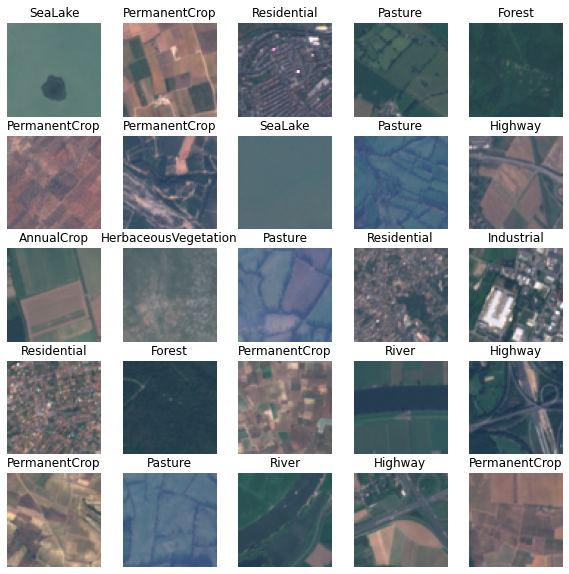

In [20]:
images, class_ids = next(training_set)
plt.figure(figsize=(10, 10))
for index in range(5 * 5):
    plt.subplot(5, 5, index + 1)
    plt.imshow(images[index])
    plt.title(ClassName_list[class_ids[index].astype(bool)][0])
    plt.axis("off")

## VGG16 model and tuning

Next the model was built, by calling a pre-trained model VGG16  (ref to paper) as this has been shown to work well previously (insert reference to paper here).  It was trained on the NVIDIA titan black GPUs, and is popular due to its accuracy and ease of application. Full description of the architecture is described in the literature ‘Very Deep Convolutional Networks For Large-Scale Image Recognition’ (Simonya and Zisserman 2015) This model starts with an input layer, then two convolutional layers, and a Max pooling layer. These layers are then repeated, there are then 3 convolutional layers, and a Max pooling layer, then repeated 3 times. The filters have a small receptive field of 3x3. There is a convolution stride and spatial padding is fixed to 1 pixel for the 3x3 convolutional layers to preserve spatial resolution.  The max pooling layers which are interjected between the convolutional layers are present for Spatial pooling, and is over a 2x2 pixel widow the convolutional stride 2. 

In [21]:
base_model = VGG16(include_top=False, input_shape=(64, 64, 3))
base_model.summary()

58900480/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                              

To this the model was set as sequential and initially a Flatten layer was added to convert the pooled feature map generated by the convolutional layers into a long vector as an input for fitting the model. This is a multi-class model, so a softmax activation was chosen.  

In [22]:
ClassName_model = len(ClassName_list)
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(units=512, activation="relu", kernel_initializer="he_normal"))
model.add(Dense(ClassName_model, activation="softmax"))

Dropout was also added at 50% here, however had been set 20% in 2.6 to reduce overfitting and improve the performance of the model on validation.

The model was also giving fairly inconsistent results. The model was tuned with an additional layer, a weight initialisation layer to improve the consistency of the weights of the model every time it is run. Though Xavier weight initialisation and Normalised Xavier weight distribution was explored. The he normaliser was chosen with a Relu activation, as it seems that a ReLu activation on this layer would be better for a multi-class dataset. To summarise the calculation: a random number with a Gaussian probability distribution with a mean of 0.0 and a standard deviation of sqrt(2/n), where n is the number of inputs to the node. 

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 2, 2, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dense_1 (Dense)             (None, 10)                5130      
                                                                 
Total params: 15,768,906
Trainable params: 15,768,906
Non-trainable params: 0
_________________________________________________________________


Compiling the model below

In [24]:
model.compile(loss="categorical_crossentropy", optimizer=Adam(learning_rate=1e-4), metrics=["accuracy"])

One of the first callbacks added was a model check point to save the best weights of the model after every epoch. Validation loss was chosen by way of monitoring and deciding the weights. The file created with the request to only save the best weights, was then used later to run the model on the test data. 
Next early stopping was added to stop the model from running when improvements plateau. Initially the model was being run on the training and validation set for 100 epochs, however the accuracy and loss seemed unchanged between epochs 28-35 upon running the model several times. The patience was set to 25, 15, and 5 to see if there would be any difference to the model. 

It was thought that managing the learning rate (this is amount that the weights are updated during training) better might improve the model. The learning rate defines how much change is required in the model. This change being in response to the estimated error each time the model weights are updated. If it’s too small, training might be far longer than it needs to be and break down. If too large the training of the data may become unstable or learn on a set of weights which are not meeting the ideal of being the best possible. 

It's fairly difficult, in terms of experience and cognizance on the matter to apply a learning rate, so ReduceLROnPlateau was also added, to improve confidence in the learning rate of the model. It monitors a quantity, in this instance based on validation loss and if no improvement is seen for a number of epochs, the learning rate is reduced. The threshold is set by the ‘patience’ which was set to 5. 


In [25]:
callbacks = [
             keras.callbacks.ModelCheckpoint(
 filepath="Classification_first_go",
 save_best_only=True,
 monitor="val_loss"),
 ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5),
 EarlyStopping(monitor="val_loss", patience=15, restore_best_weights=True, verbose=True)
]



The code below was that which was used to train the data and compare to the validation group:

In [26]:
history = model.fit(
    training_set,
    validation_data=validation_set,
    callbacks=callbacks, 
    epochs=50,
    verbose=1,
)

Epoch 1/50
378/378 [==============================] - 86s 191ms/step - loss: 0.6729 - accuracy: 0.7683 - val_loss: 0.2243 - val_accuracy: 0.9317 - lr: 1.0000e-04
Epoch 2/50
378/378 [==============================] - 70s 185ms/step - loss: 0.2339 - accuracy: 0.9276 - val_loss: 0.1593 - val_accuracy: 0.9483 - lr: 1.0000e-04
Epoch 3/50
378/378 [==============================] - 66s 174ms/step - loss: 0.1579 - accuracy: 0.9501 - val_loss: 0.1696 - val_accuracy: 0.9478 - lr: 1.0000e-04
Epoch 4/50
378/378 [==============================] - 66s 174ms/step - loss: 0.1270 - accuracy: 0.9586 - val_loss: 0.1650 - val_accuracy: 0.9526 - lr: 1.0000e-04
Epoch 5/50
378/378 [==============================] - 70s 185ms/step - loss: 0.1116 - accuracy: 0.9650 - val_loss: 0.1154 - val_accuracy: 0.9669 - lr: 1.0000e-04
Epoch 6/50
378/378 [==============================] - 66s 174ms/step - loss: 0.1049 - accuracy: 0.9666 - val_loss: 0.1582 - val_accuracy: 0.9526 - lr: 1.0000e-04
Epoch 7/50
378/378 [========

After running several times, the request for early stopping lead to the model to stop running between epoch 32 and 34. 

## Results for VGG16 and tuning

Following this, accuracy and loss for training and validation was explored with some simple data visualisation. 

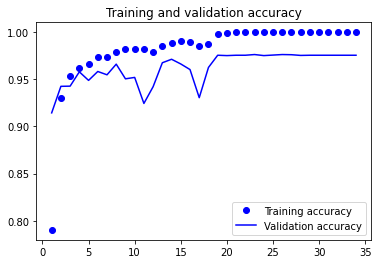

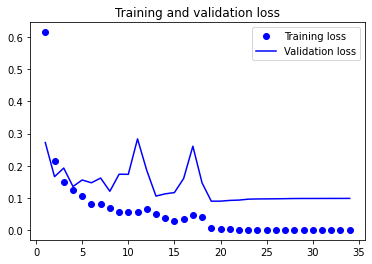

In [ ]:
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [ ]:
test_model = keras.models.load_model("Classification_first_go")
test_loss, test_acc = test_model.evaluate(test_set) 
print(f"Test accuracy: {test_acc:.3f}")

43/43 [==============================] - 5s 106ms/step - loss: 0.0742 - accuracy: 0.9833
Test accuracy: 0.983


In model the best weights were to be found at epoch 19, yielding an overall accuracy of 99%, validation loss of 9.8% and validation accuracy of 97.5%

When the model in notebook 2.6 was deployed over the test data, it yielded a test accuracy of 98%


## Data Augmentation

In the interest of possible improvmenets to the accuracy and loss of the model, and fixing the peaks in the graphs for training and validation losses an dacuuracies Data augmentation is attempted. We try randomly flipping the images, rotating them and zooming. 

In [35]:
data_augmentation = keras.Sequential(
 [
 layers.RandomFlip("horizontal") 
 layers.RandomRotation(0.1),
 layers.RandomZoom(0.2),
 ]
)

Once again we can explore what these images look like, and there are some mild differences upon exploration to the author most noticable with the zoom. Given the way Sentinel-2 images are collected, at a consistent distance and the images all being 64x64 pixels it's possible that the data augmentation technique used here make not make too much of a difference to the model. However it is also possible that the use of data augmentation might allow for RGB images from multiple sources depending on the accuracy that the model could be tuned to achieve and by including thousands of images from each individual source. This would be interesting to explore beyond the assignment. 

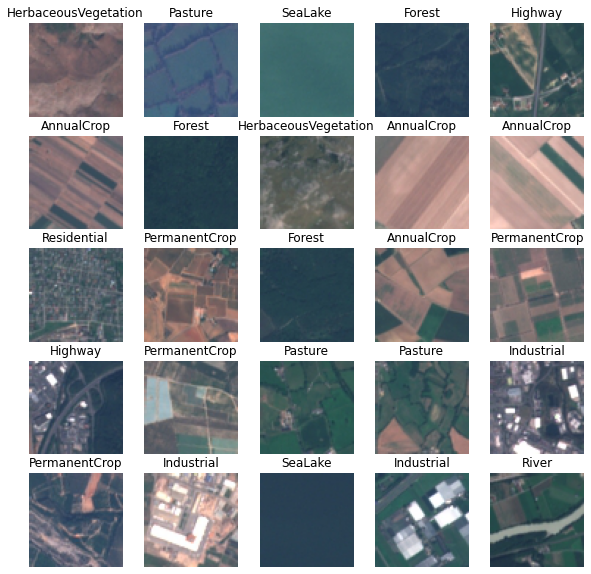

In [36]:
images, class_ids = next(training_set)
plt.figure(figsize=(10, 10))
for index in range(5 * 5):
    plt.subplot(5, 5, index + 1)
    plt.imshow(data_augmentation(images[index]))
    plt.title(ClassName_list[class_ids[index].astype(bool)][0])
    plt.axis("off")

In [37]:
ClassName_model = len(ClassName_list)
model = Sequential()
model.add(data_augmentation)
model.add(base_model)
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(units=512, activation="relu", kernel_initializer="he_normal"))
model.add(Dense(ClassName_model, activation="softmax"))

In [38]:
callbacks = [
             keras.callbacks.ModelCheckpoint(
 filepath="Classification_second_go",
 save_best_only=True,
 monitor="val_loss"),
 ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5),
 EarlyStopping(monitor="val_loss", patience=15, restore_best_weights=True, verbose=True)
]

In [39]:
model.compile(loss="categorical_crossentropy", optimizer=Adam(learning_rate=1e-4), metrics=["val_loss"])

In [40]:
history = model.fit(
    training_set,
    validation_data=validation_set,
    callbacks=callbacks, 
    epochs=50,
    verbose=1,
)

Epoch 1/50
378/378 [==============================] - ETA: 0s - loss: 0.1787 - accuracy: 0.9493WARNING:tensorflow:Model was constructed with shape (64, 64, 3) for input KerasTensor(type_spec=TensorSpec(shape=(64, 64, 3), dtype=tf.float32, name='random_rotation_1_input'), name='random_rotation_1_input', description="created by layer 'random_rotation_1_input'"), but it was called on an input with incompatible shape (None, None, None, None).
INFO:tensorflow:Assets written to: Classification_second_go/assets
378/378 [==============================] - 36s 93ms/step - loss: 0.1787 - accuracy: 0.9493 - val_loss: 0.2010 - val_accuracy: 0.9472 - lr: 1.0000e-04
Epoch 2/50
378/378 [==============================] - ETA: 0s - loss: 0.1181 - accuracy: 0.9640WARNING:tensorflow:Model was constructed with shape (None, 64, 3) for input KerasTensor(type_spec=TensorSpec(shape=(None, 64, 3), dtype=tf.float32, name='random_rotation_1_input'), name='random_rotation_1_input', description="created by layer 'r

Here the model is giving a loss of 0.6% an accuracy of 99%, with a validation loss of 1% and validation accuracy of 97% So very similar to the previous model. 

It is interesting to note that for some of the epochs, there is a warning that the model construction of VGG16 wasn't compatible with the horizontal flipping in the Data augmentation. So these inputs would only show some loss and no accuracy. It's suspected that in this instance Data Augmentation actually reduces the training set by an unknown number so making this particularly model less reliable than the incarnation of the model above without data augmentation.  

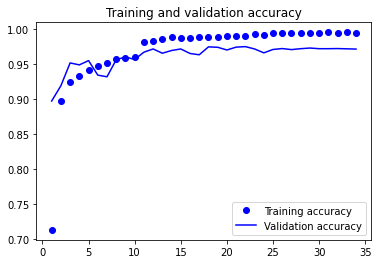

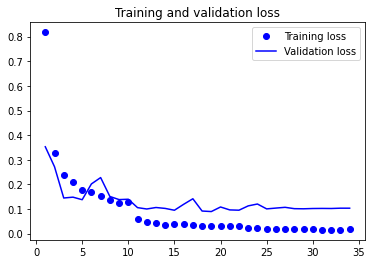

In [33]:
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

The curves on the graphs for training and validation loss, are slightly smoother but there doesn;t appear to be any huge gains in terms of improvement to either the respective training losses and accuracies. 

In [48]:
test_model = keras.models.load_model("Classification_second_go")
test_loss, test_acc = test_model.evaluate(test_set) 
print(f"Test accuracy: {test_acc:.3f}")

54/54 [==============================] - 2s 30ms/step - loss: 0.0794 - accuracy: 0.9811
Test accuracy: 0.981


The model with Data augment achieved an accuracy of 98% which is the same as the model without data augmentation. 

# Discussion

For the VGG16 model without Data AUgmentation the graph for loss, the training loss is less than the validation loss which is what would be expected in a reasonably good model. 

In the graph for training and validation accuracy, the training accuracy is also better than validation accuracy which is in keeping with expectations of a good deep learning model. 

In terms of the positions of the curves for validation loss, and training loss, there is a difference of 1% where validation loss is slightly worse. This is indicative of some overfitting. 

The analysis would have benefitted from the application of a confusion matrix to look at the rate of false positives and false negative class by class. This would have given more granularity to the analysis and possibly greater confidence in the model. 

For both the jagged shape of the curves for validation loss and accuracy is expected due to the application of drop out imposing a limitation on the amount of data. During the drop out, a percentage of the feature map are set to zero during training in comparison to when the model with the full feature map is run on the test data. The process of using drop out should lead to a more robust model yielding higher testing accuracy. In terms of the difference between the application of the different percentages of drop out, while 20% results in a better and more consistent curve for training loss, the performance of the model was slightly worse on validation loss than that of 50%. Due to this it’s felt that the application of 50% drop out is a better compromise in terms

VGG16 was selected as a pretrained model as it had shown to work well in previous literature on RGB satellite images however it would be interesting to take a multi-model approach in future including comparisons between the models ResNet-50 and GoogleLeNet (ref EuroSAT: A Novel Dataset and Deep Learning Benchmark for Land Use and Land Cover Classification Helber et al) to see if this could yield any improvement to accuracies. 

The graphs for the Training and validation losses and accuracies showed two distinct peaks, and this could be due to some homogeneity in the RGB values of some of the images across the different classes. Forests, Herbaceous vegetation and some river and sea lake images have a lot of green in them. 

Data Augmentation was used to try and ameliorate this, specifically flipping, zoom and rotation. While it did lead to small drop in accuracy it did reduce the size of the peaks in the training and validation losses and accuracies.  
There was a slight imbalance seen in the original dataset. In the training group, the numbers of images in the different classes ranged from 1400 to 2100 which while not excessive, would have been good for further exploration in terms of model improvement. When a model is imbalanced there is a chance that what is approached as a multiclass problem can be treated as a binary problem by the model. Out of scope for this assignment, but interesting none the less would be to approach the classification question for each class individually. So running the VGG16 model on single class training, validation and test datasets as a binary classification problem. This would allow observation of the individual accuracies and compare performance and dependencies.  

Given more time, it would be an interesting facet of the analysis of the effectiveness of the model to apply a receiver operating characteristic curve (ROC) and Area under the ROC curve (as part of the analysis). ROC would give an overview of how the model was performing at all classification thresholds by plotting the true positive rate and false positive rate. This alongside AUC which is an aggregate of performance measurements across all the classification thresholds, focussed on the ranking of the performance rather than absolute values. This would have given a more effective picture of if and how the imbalance of the data was affecting the model. 

Finally, had the programmatic splitting of the dataset had been workable later in the pipeline, cross validation would have been explored to look at the effect of splitting the dataset in different ways and to then analyse the dependencies on this. 

When considering the possible uses for this type of machine learning classification problem, it would be interesting to look at ways to apply uncertainty measurement as a probability distribution function. Uncertainty analysis is a process of estimating the uncertainty of a measured value. Epistemic uncertainty is uncertainty which arises from the model itself due to a lack of knowledge. It can be reduced by the collection and accumulation of more data and increasing the size of the training sets. Aleatoric uncertainty is uncertainty associated with the data itself, it cannot be reduced and reflects a difference between random and systematic patterns in the data itself. There are different equations and algorithms under research and in use such as ensemble methods. 
  
It would be interesting to observe the effect of the addition of some code for the uncertainty calculations to a data augmentation step in the pipeline. Another way of introducing this could be programmatically applying an algorithm appropriate for the type of uncertainty being observed, for uncertainty measurement to the model by way of dense layer.  

The importance of this type of deep learning model building for land classification problems is building capability in terms of providing temporal mapping and analysis of land and water under the context of Climate preservation and recovery as well changing use. Essentially providing the tools to build inventories of the current land types in an area and facilitate the research in the distribution of carbon pools, eco-systems and demography. This then enables further research and metrology in terms of Climate health. 

Economically, there is also scope for these kinds of machine learning tools to be used in the interests of landowners benefitting from Government programmes of tax relief, benefits and credits. The Carbon credit programme in the UK being an example. Politically, there are also benefits from the point of view of Government policy in being able to reconcile and validate land use, being in a position to improve confidence level in the distribution of funds and credits. There could also be a use case in terms of monitoring overcrowding, and urban sprawl in terms of being able to classify temporally its growth and decline. Being in a position to use this data to corroborate impact to the flora and fauna of the area and further inform policies around the environment or construction.   





## References



1. Chollet, F. (2018). Deep Learning with Python. Shelter Island (New York, Estados Unidos): Manning, Cop. 

2. Helber, P., Bischke, B., Dengel, A. and Borth, D. (2019). EuroSAT: A Novel Dataset and Deep Learning Benchmark for Land Use and Land Cover Classification. IEEE Journal of Selected Topics in Applied Earth Observations and Remote Sensing, [online] 12(7), pp.2217–2226. Available at: https://ieeexplore.ieee.org/document/8736785.

3.   Pirotti, F., Sunar, F. and Piragnolo, M. (2016). BENCHMARK OF MACHINE LEARNING METHODS FOR CLASSIFICATION OF A SENTINEL-2 IMAGE. ISPRS - International Archives of the Photogrammetry, Remote Sensing and Spatial Information Sciences, [online] XLI-B7, pp.335–340. Available at: https://www.int-arch-photogramm-remote-sens-spatial-inf-sci.net/XLI-B7/335/2016/isprs-archives-XLI-B7-335-2016.pdf.

4. Solomatine, D.P. and Shrestha, D.L., 2009. A novel method to estimate model uncertainty using machine learning techniques. Water Resources Research, 45(12).

5. He, K., Zhang, X., Ren, S. and Sun, J., 2015. Delving deep into rectifiers: Surpassing human-level performance on imagenet classification. In Proceedings of the IEEE international conference on computer vision (pp. 1026-1034).

6. Xavier Glorot, Yoshua Bengio Proceedings of the Thirteenth International Conference on Artificial Intelligence and Statistics, PMLR 9:249-256, 2010

7. Wooliams, E., Mittaz, J., Merchant, C. and Harris, P., 2017. FIDUCEO project: Principles behind the FCDR effects table.

8. Fox, N., Kaiser-Weiss, A., Schmutz, W., Thome, K., Young, D., Wielicki, B., Winkler, R. and Woolliams, E., 2011. Accurate radiometry from space: an essential tool for climate studies. Philosophical Transactions of the Royal Society A: Mathematical, Physical and Engineering Sciences, 369(1953), pp.4028-4063.

9. Mittaz, J., Merchant, C.J. and Woolliams, E.R., 2019. Applying principles of metrology to historical Earth observations from satellites. Metrologia, 56(3), p.032002.

10. Brownlee, J. (2021). Weight Initialization for Deep Learning Neural Networks. [online] Machine Learning Mastery. Available at: https://machinelearningmastery.com/weight-initialization-for-deep-learning-neural-networks/#:~:text=each%20in%20turn.

6. Chollet, F. & others, 2015. Keras. Available at: https://github.com/fchollet/keras


7. Team, K. (n.d.). Keras documentation: Layer weight initializers. [online] keras.io. Available at: https://keras.io/api/layers/initializers/.


8. Team, K. (n.d.). Keras documentation: Layer weight regularizers. [online] keras.io. Available at: https://keras.io/api/layers/regularizers/.


9. Team, K. (n.d.). Keras documentation: ReduceLROnPlateau. [online] keras.io. Available at: https://keras.io/api/callbacks/reduce_lr_on_plateau/.

10. Brownlee, J. (2021). Weight Initialization for Deep Learning Neural Networks. [online] Machine Learning Mastery. Available at: https://machinelearningmastery.com/weight-initialization-for-deep-learning-neural-networks/.

11. Team, K. (n.d.). Keras documentation: Normalization layer. [online] keras.io. Available at: https://keras.io/api/layers/preprocessing_layers/numerical/normalization/

12. Scikit-learn.org. (2018). sklearn.model_selection.train_test_split — scikit-learn 0.20.3 documentation. [online] Available at: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

13. Team, K. (n.d.). Keras documentation: Flatten layer. [online] keras.io. Available at: https://keras.io/api/layers/reshaping_layers/flatten/.

14. Team, K. (n.d.). Keras documentation: Dropout layer. [online] keras.io. Available at: https://keras.io/api/layers/regularization_layers/dropout/.

15. J, V. (2019). Tutorial on Keras flow_from_dataframe. [online] Medium. Available at: https://vijayabhaskar96.medium.com/tutorial-on-keras-flow-from-dataframe-1fd4493d237c.

15. Team, K. (n.d.). Keras documentation: EarlyStopping. [online] keras.io. Available at: https://keras.io/api/callbacks/early_stopping/.

16. matplotlib.org. (n.d.). Matplotlib: Python plotting — Matplotlib 3.3.4 documentation. [online] Available at: https://matplotlib.org/stable/index.html.

18. pillow.readthedocs.io. (n.d.). Tutorial. [online] Available at: https://pillow.readthedocs.io/en/stable/handbook/tutorial.html.

‌





‌



END